# Projects and automated ML pipeline

This notebook demonstrates how to work with projects, source control (git), and automating the ML pipeline.

Make sure you went over the basics in MLRun [**Quick Start Tutorial**](./01-mlrun-basics.html).

MLRun Project is a container for all your work on a particular activity: all the associated code, [functions](https://docs.mlrun.org/en/latest/runtimes/functions.html), [jobs](https://docs.mlrun.org/en/latest/concepts/submitting-tasks-jobs-to-functions.html), [workflows](https://docs.mlrun.org/en/latest/concepts/workflow-overview.html), data, models, and [artifacts](https://docs.mlrun.org/en/latest/store/artifacts.html). Projects can be mapped to `git` repositories to enable versioning, collaboration, and [CI/CD](../projects/ci-integration.html).

You can create project definitions using the SDK or a yaml file and store those in the MLRun DB, a file, or an archive.
Once the project is loaded you can run jobs/workflows that refer to any project element by name, allowing separation between configuration and code. See [load projects](../projects/load-project.html) for details.

Projects contain `workflows` that execute the registered functions in a sequence/graph (DAG), and that can reference project parameters, secrets and artifacts by name. MLRun currently supports two workflow engines, `local` (for simple tasks) and [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/pipelines-quickstart/) (for more complex/advanced tasks). MLRun also supports a real-time workflow engine (see [online serving pipelines (graphs)](https://docs.mlrun.org/en/latest/serving/serving-graph.html). 

An ML Engineer can gather the different functions created by the data engineer and data scientist and create this automated pipeline.

Tutorial steps:
- [**Set up the project and functions**](#project)
- [**Work with GIT and archives**](#archives)
- [**Build and run automated ML pipelines and CI/CD**](#pipeline)
- [**Test the deployed model endpoint**](#test-model)

## MLRun installation and configuration

Before running this notebook make sure the `mlrun` package is installed (`pip install mlrun`) and that you have configured the access to MLRun service. 

In [1]:
# Install MLRun if not installed, run this only once (restart the notebook after the install !!!)
%pip install mlrun

Note: you may need to restart the kernel to use updated packages.


<a id="project"></a>
## Set up the project and functions

**Get or create a project**

There are three ways to create/load [**MLRun projects**](https://docs.mlrun.org/en/latest/projects/project.html):
* `mlrun.projects.new_project()`  &mdash; Create a new MLRun project and optionally load it from a yaml/zip/git template.
* `mlrun.projects.load_project()` &mdash; Load a project from a context directory or remote git/zip/tar archive.
* `mlrun.projects.get_or_create_project()` &mdash; Load a project from the MLRun DB if it exists, or from a specified 
  context/archive. 

Projects refer to a `context` directory that holds all the project code and configuration. The `context` dir is 
usually mapped to a `git` repository and/or to an IDE (PyCharm, VSCode, etc.) project.   

In [2]:
import mlrun
project = mlrun.get_or_create_project("tutorial", context="./", user_project=True)

> 2022-12-17 19:56:01,846 [info] loaded project tutorial from MLRun DB


<a id="gs-tutorial-4-step-setting-up-project"></a>

### Register project functions

To run workflows, you must save the definitions for the functions in the project so that function objects are initialized 
automatically when you load a project or when running a project version in automated CI/CD workflows. In addition, you might want to set/register other project attributes such as global parameters, secrets, and data.

Functions are registered using the `set_function()` command, where you can specify the code, requirements, image, etc. 
Functions can be created from a single code/notebook file or have access to the entire project context directory. (By adding the `with_repo=True` flag, it guarantees that the project context is cloned into the function runtime environment).

Function registration examples:

```python
    # Example: register a notebook file as a function
    project.set_function('mynb.ipynb', name='test-function', image="mlrun/mlrun", handler="run_test")

    # Define a job (batch) function that uses code/libs from the project repo
    project.set_function(
        name="myjob", handler="my_module.job_handler",
        image="mlrun/mlrun", kind="job", with_repo=True,
    )
```

**Function code**

Run the following cell to generate the data prep file (or copy it manually):

In [3]:
%%writefile data-prep.py

import pandas as pd
from sklearn.datasets import load_breast_cancer

import mlrun


@mlrun.handler(outputs=["dataset", "label_column"])
def breast_cancer_generator():
    """
    A function that generates the breast cancer dataset
    """
    breast_cancer = load_breast_cancer()
    breast_cancer_dataset = pd.DataFrame(
        data=breast_cancer.data, columns=breast_cancer.feature_names
    )
    breast_cancer_labels = pd.DataFrame(data=breast_cancer.target, columns=["label"])
    breast_cancer_dataset = pd.concat(
        [breast_cancer_dataset, breast_cancer_labels], axis=1
    )

    return breast_cancer_dataset, "label"

Overwriting data-prep.py


**Register the function above in the project**

In [4]:
project.set_function("data-prep.py", name="data-prep", kind="job", image="mlrun/mlrun", handler="breast_cancer_generator")

**Register additional project objects and metadata**

You can define other objects (workflows, artifacts, secrets) and parameters in the project and use them in your functions, for example:

```python
    # Register a simple named artifact in the project (to be used in workflows)  
    data_url = 'https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv'
    project.set_artifact('data', target_path=data_url)

    # Add a multi-stage workflow (./workflow.py) to the project with the name 'main' and save the project 
    project.set_workflow('main', "./workflow.py")
    
    # Read env vars from dict or file and set as project secrets
    project.set_secrets({"SECRET1": "value"})
    project.set_secrets(file_path="secrets.env")
    
    project.spec.params = {"x": 5}
```

**Save the project**

In [5]:
# Save the project in the db (and into the project.yaml file)
project.save()

When you save the project it stores the project definitions in the `project.yaml`. This allows reconstructing the project in a remote cluster or a CI/CD system. 

See the generated project file: [**project.yaml**](project.yaml).

<a id="archives"></a>
## Work with GIT and archives

### Push the project code/metadata into an archive

Use standard git commands to push the current project tree into a git archive. Make sure you `.save()` the project before pushing it.

    git remote add origin <server>
    git commit -m "Commit message"
    git push origin master

Alternatively, you can use MLRun SDK calls:
- `project.create_remote(git_uri, branch=branch)` &mdash; to register the remote Git path
- `project.push()` &mdash; save the project state and commit/push updates to the remote git repo

You can also save the project content and metadata into a local or remote `.zip` archive, for example: 

    project.export("../archive1.zip")
    project.export("s3://my-bucket/archive1.zip")
    project.export(f"v3io://projects/{project.name}/archive1.zip")
    

<a id='load'></a>
### Load a project from local/remote archive 

The project metadata and context (code and configuration) can be loaded and initialized using the {py:meth}`~mlrun.projects.load_project` method.
When `url` (of the git/zip/tar) is specified, it clones a remote repo into the local `context` dir.

    # Load the project and run the 'main' workflow
    project = load_project(context="./", name="myproj", url="git://github.com/mlrun/project-archive.git")
    project.run("main", arguments={'data': data_url})

Projects can also be loaded and executed using the CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-archive.git" .
    mlrun project -r main -w -a data=<data-url> .

In [6]:
# load the project in the current context dir
project = mlrun.load_project("./")

<a id="pipeline"></a>
## Build and run automated ML pipelines and CI/CD

A pipeline is created by running an MLRun **"workflow"**.
The following code defines a workflow and writes it to a file in your local directory, with the file name **workflow.py**.
The workflow describes a directed acyclic graph (DAG) which is executed using the `local`, `remote`, or `kubeflow` engines.

See [running a multi-stage workflow](https://docs.mlrun.org/en/latest/concepts/workflow-overview.html).
The defined pipeline includes the following steps:

- Generate/prepare the data (`ingest`).
- Train and the model (`train`).
- Deploy the model as a real-time serverless function (`serving`).

```{admonition} Note
A pipeline can also include continuous build integration and deployment (CI/CD) steps, such as building container images and deploying models.
```

In [7]:
%%writefile './workflow.py'

from kfp import dsl
import mlrun

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(name="breast-cancer-demo")
def pipeline(model_name="cancer-classifier"):
    # Run the ingestion function with the new image and params
    ingest = mlrun.run_function(
        "data-prep",
        name="get-data",
        outputs=["dataset"],
    )

    # Train a model using the auto_trainer hub function
    train = mlrun.run_function(
        "hub://auto_trainer",
        inputs={"dataset": ingest.outputs["dataset"]},
        params = {
            "model_class": "sklearn.ensemble.RandomForestClassifier",
            "train_test_split_size": 0.2,
            "label_columns": "label",
            "model_name": model_name,
        }, 
        handler='train',
        outputs=["model"],
    )

    # Deploy the trained model as a serverless function
    serving_fn = mlrun.new_function("serving", image="mlrun/mlrun", kind="serving")
    serving_fn.with_code(body=" ")
    mlrun.deploy_function(
        serving_fn,
        models=[
            {
                "key": model_name,
                "model_path": train.outputs["model"],
                "class_name": 'mlrun.frameworks.sklearn.SklearnModelServer',
            }
        ],
    )

Writing ./workflow.py


<a id="gs-tutorial-4-step-register-workflow"></a>

**Run the workflow**

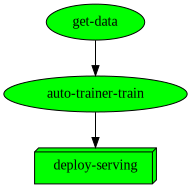

uid,start,state,name,parameters,results
...d46a38aa,Dec 17 19:56:47,completed,auto-trainer-train,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=cancer-classifier,accuracy=0.9912280701754386f1_score=0.9919999999999999precision_score=0.9841269841269841recall_score=1.0
...bb51d992,Dec 17 19:56:15,completed,get-data,,label_column=label


In [8]:
# Run the workflow
run_id = project.run(
    workflow_path="./workflow.py",
    arguments={"model_name": "cancer-classifier"}, 
    watch=True)

<br>

**View the pipeline in MLRun UI**

![workflow](../_static/images/tutorial/workflow.png)

<br>

**Run workflows using the CLI**

With MLRun you can use a single command to load the code from local dir or remote archive (Git, zip, ..) and execute a pipeline. This can be very useful for integration with CI/CD frameworks and practices. See [CI/CD integration](https://docs.mlrun.org/en/latest/projects/ci-integration.html) for more details.

The following command loads the project from the current dir (`.`) and executes the workflow with an argument, for running locally (without k8s).

    mlrun project -r ./workflow.py -w -a model_name=classifier2 .!mlrun project -r ./workflow.py -w -a model_name=classifier2 .

<a id="test-model"></a>
## Test the deployed model endpoint

Now that your model is deployed using the pipeline, you can invoke it as usual:

In [9]:
serving_fn = project.get_function("serving")

In [10]:
# Create a mock (simulator of the real-time function)
my_data = {"inputs"
           :[[
               1.371e+01, 2.083e+01, 9.020e+01, 5.779e+02, 1.189e-01, 1.645e-01,
               9.366e-02, 5.985e-02, 2.196e-01, 7.451e-02, 5.835e-01, 1.377e+00,
               3.856e+00, 5.096e+01, 8.805e-03, 3.029e-02, 2.488e-02, 1.448e-02,
               1.486e-02, 5.412e-03, 1.706e+01, 2.814e+01, 1.106e+02, 8.970e+02,
               1.654e-01, 3.682e-01, 2.678e-01, 1.556e-01, 3.196e-01, 1.151e-01]
            ]
}
serving_fn.invoke("/v2/models/cancer-classifier/infer", body=my_data)

> 2022-12-17 19:58:37,874 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-tutorial-dani-serving.default-tenant.svc.cluster.local:8080/v2/models/cancer-classifier/infer'}


{'id': '2a87a7a7-bddc-4293-a594-6d49c03f9259',
 'model_name': 'cancer-classifier',
 'outputs': [0]}

## Done!

Congratulations! You’ve completed Part 4 of the MLRun getting-started tutorial. To continue, proceed to [ Part 5 Model monitoring and drift detection](https://docs.mlrun.org/en/latest/tutorial/05-model-monitoring.html).

You might also want to explore the following demos:

- For an example of distributed training pipeline using TensorFlow, Keras, and PyTorch, see the [**mask detection demo**](https://github.com/mlrun/demos/tree/1.2.x/mask-detection).
- To learn more about deploying live endpoints and concept drift, see the [**network-operations (NetOps) demo**](https://github.com/mlrun/demos/tree/1.2.x/network-operations).
- To learn about using the feature store to process raw transactions and events in real-time and respond and block transactions before they occur, see the [**Fraud prevention demo**](https://github.com/mlrun/demos/tree/1.2.x/fraud-prevention-feature-store).  
- For an example of a pipeline that summarizes and extracts keywords from a news article URL, see the [**News article summarization and keyword extraction via NLP**](https://github.com/mlrun/demos/tree/1.2.x/news-article-nlp).